# Simulate bets on last 100 matches

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statistics
import time

In [78]:
# Import dataframe
df = pd.read_pickle("test_100.pkl")

## Simulate last 500

In [2]:
# Import dataframe
df = pd.read_pickle("test_500.pkl")

In [8]:
# We will bet on an outcome if the bookmakers have given us better odds than our model.
# In the case where 2 different outcomes are larger than predicted (e.g. Home and Draw), we will bet on the one that has the largest relative difference in probabilities to our model.

# empty list for expected returns
all_exp_returns = []

def create_bet_max(df):
    all_bet_max = []
    for _, row in df.iterrows():
        bet_max = [0, 0, 0]
        # Find largest relative difference in probabilities
        home_diff = row['model_1_probs'][0] / (1/(row['max_odds'][0]))
        draw_diff = row['model_1_probs'][1] / (1/(row['max_odds'][1]))
        away_diff = row['model_1_probs'][2] / (1/(row['max_odds'][2]))
        max_diff = max(home_diff, draw_diff, away_diff)
        # If ratio higher than 1, it is worth it to bet.
        if max_diff > 1:
            if max_diff == home_diff:
                bet_max[0] = row['max_odds'][0]
            elif max_diff == draw_diff:
                bet_max[1] = row['max_odds'][1]
            else:
                bet_max[2] = row['max_odds'][2]
        all_bet_max.append(bet_max)

        # Find average expected return
        all_exp_returns.append(max_diff)

    df['bet_max'] = all_bet_max


create_bet_max(df)
sum(all_exp_returns)/len(all_exp_returns) # Average expected return

1.3007955112764242

In [4]:
# We will use the Kelly criterion to determine how much to bet for each match we want to bet on.
def kelly_crit(model_odds, bookie_odds, bankroll):
    """
    Kelly Criterion formula, that calculates the fraction of the bankroll to bet depending on our model odds and the bookmaker's odds.
    """
    bet_fraction = ((1/model_odds)*bookie_odds - 1)/(bookie_odds - 1)
    bet_amount = bet_fraction*bankroll
    return bet_amount

In [5]:
bet_sizes = [] # Create list to find mean bet size

def simulate_bets(df, starting_bankroll, min_bet, max_bet):
    """
    Simulate bets using our model predictions and the best bookmaker's odds. Size bets according to Kelly Criterion, with respect to the min and max allowed bets on the bookmakers platform.
    """
    # Simulate bets
    starting_bankroll = starting_bankroll
    max_bet = max_bet
    min_bet = min_bet
    df['bet_amount'] = np.nan
    df['ending_bankroll'] = np.nan


    for outer_index, row in df.iterrows():
    
        # Get ending bankroll from previous row
        if outer_index != 0:
            bankroll = df.iloc[outer_index-1]['ending_bankroll']
        else:
            bankroll = starting_bankroll

        bookie_odds = 0
        model_odds = -1 # avoid /0 in kelly formula
    
        # If there was a bookmaker odd higher than our model's predicted odds, set to bookie_odds.
        bet_index = 0 # In case the first row bet_max is all zeros, this will cause an error in bet_winnings below.
        if sum(row['bet_max']) != 0:
            for inner_index, element in enumerate(row['bet_max']):
                if element != 0:
                    bookie_odds = element
                    bet_index = inner_index
            model_odds = row['model_1_odds'][bet_index]

        # Calculate bet amount
        if bookie_odds != 0:
            bet_amount = max(kelly_crit(model_odds, bookie_odds, bankroll), 0)
            # Set max bet amount
            bet_amount = min(bet_amount, max_bet)
            if bet_amount < min_bet:
                bet_amount = 0
        else:
            bet_amount = 0      
        df.loc[outer_index, 'bet_amount'] = bet_amount
        

        # Calculate bankroll
        bet_winnings = row['outcome'][bet_index]*bookie_odds*bet_amount
        bet_losses = bet_amount
        profit = bet_winnings - bet_losses
        df.loc[outer_index, 'ending_bankroll'] = bankroll + profit
        bet_sizes.append(bet_amount)


simulate_bets(df, 1000, 1, 200)
sum(bet_sizes)/len(bet_sizes) # mean bet size

9.10009189763301

In [6]:
# Random bets on max_odds
# Calculate the bankroll evolution if we bet randomly instead of using the model, in order to see if the model is better than random.
def random_bets(df, starting_bankroll, bet_proportion, min_bet, max_bet):
    """
    Randomly choose to bet on home, draw or away for each match, using the max odds for that bet. Bet size is a proportion of current bankroll.
    """
    df['random_bankroll'] = np.nan
    starting_bankroll = starting_bankroll
    bet_proportion = bet_proportion
    for index, row in df.iterrows():
        # Set bankroll
        if index != 0:
            bankroll = df.iloc[index-1]['random_bankroll']
        else:
            bankroll = starting_bankroll
        # Set bet to our defined bet amount, unless bankroll is smaller.
        current_bet = bankroll*bet_proportion
        if current_bet < min_bet:
            current_bet = 0
        if current_bet > max_bet:
            current_bet = max_bet
        # Choose randomly between home, draw and away.
        random_index = random.randint(0, 2)
        # Calculate profit
        bet_losses = current_bet
        bet_winnings = row['max_odds'][random_index]*row['outcome'][random_index]*current_bet
        profit = bet_winnings - bet_losses
        bankroll = bankroll + profit
        df.loc[index, 'random_bankroll'] = bankroll


random_bets(df, 1000, 0.10, 1, 200)

In [101]:
# Create aggregation of random bankrolls to find the mean for each step

def create_random_bankrolls(iterations, df, starting_bankroll, bet_proportion, min_bet, max_bet):
    random_bankrolls = []
    for i in range(iterations):
        random_bets(df, starting_bankroll, bet_proportion, min_bet, max_bet)
        random_bankrolls.append(df['random_bankroll'].tolist())
    return random_bankrolls


start_time = time.time()
random_bankrolls = create_random_bankrolls(5000, df, 1000, 0.10, 1, 200)
end_time = time.time()
print("Time to create random bankrolls: {}".format(end_time-start_time))

Time to create random bankrolls: 459.42723512649536


In [102]:
mean_bankroll = [sum(values)/len(values) for values in zip(*random_bankrolls)]
df['mean_bankroll'] = mean_bankroll
median_bankroll = [statistics.median(values) for values in zip(*random_bankrolls)]
df['median_bankroll'] = median_bankroll

In [7]:
df.tail(3)

,match,teams,score,ht_score,date,formations,players,fifa_ids,closest_update,second_closest_update,...,WH_odds,VC_odds,max_odds,features,model_1_probs,model_1_odds,bet_max,bet_amount,ending_bankroll,random_bankroll
497,93635,"[Fulham, Newcastle]","[0, 1]","[0, 0]",2024-04-06,"[4-2-3-1, 4-3-3]","[[Bernd Leno, Goalkeeper, 4985], [Calvin Basse...","[192563, 241436, 222104, 222501, 229348, 20845...",2024-03-27,2024-03-20,...,"[2.3, 3.9, 2.7]","[2.3, 3.7, 2.7]","[2.38, 3.9, 2.86]","[0.47, 0.47, 0.64, 0.5, 0.52, 0.52, 0.56, 0.54...","[0.41143977642059326, 0.282823771238327, 0.305...","[2.43, 3.54, 3.27]","[0, 3.9, 0]",0.0,2.298561,9.40077
498,93636,"[Luton, Bournemouth]","[2, 1]","[0, 0]",2024-04-06,"[3-4-2-1, 4-2-3-1]","[[Thomas Kaminski, Goalkeeper, 5844], [Teden M...","[188400, 253465, 221456, 253052, 202464, 25248...",2024-03-27,2024-03-20,...,"[3.6, 4.2, 1.85]","[3.6, 3.8, 1.87]","[3.75, 4.2, 1.93]","[0.13, 0.87, 0.5, 0.44, 0.4, 0.46, 0.42, 0.46,...","[0.42432451248168945, 0.24066321551799774, 0.3...","[2.36, 4.16, 2.98]","[3.75, 0, 0]",0.0,2.298561,9.40077
499,93640,"[Wolves, West Ham]","[1, 2]","[1, 0]",2024-04-06,"[3-4-2-1, 4-2-3-1]","[[José Sá, Goalkeeper, 15715], [Maximilian Kil...","[212442, 245336, 258607, 237658, 201417, 27346...",2024-03-27,2024-03-20,...,"[2.4, 3.6, 2.7]","[2.45, 3.4, 2.7]","[2.53, 3.61, 2.77]","[0.47, 0.4, 0.58, 0.54, 0.52, 0.54, 0.48, 0.54...","[0.3892717957496643, 0.30281779170036316, 0.30...","[2.57, 3.3, 3.25]","[0, 3.61, 0]",0.0,2.298561,9.40077


Text(0.5, 1.0, 'Bankroll value over matches')

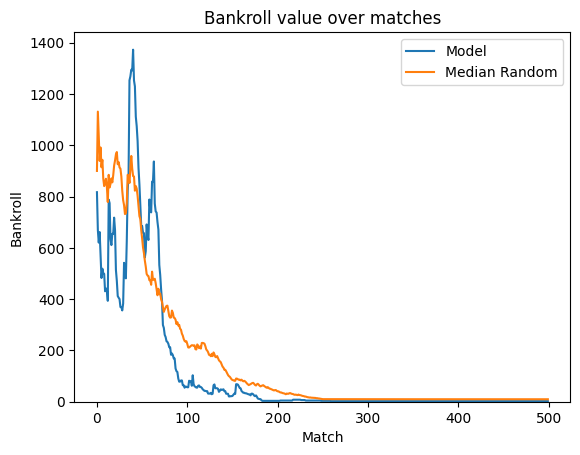

In [113]:
# Plot bankroll over matches
plt.plot(df['ending_bankroll'], label='Model')
plt.plot(df['median_bankroll'], label='Median Random')
plt.xlabel('Match')
plt.ylabel('Bankroll')
plt.ylim(bottom=0)
plt.legend()
plt.title('Bankroll value over matches')
#plt.savefig('test_100.png')
#plt.savefig('test_500.png')

In [115]:
df.iloc[0:25]

,match,teams,score,ht_score,date,formations,players,fifa_ids,closest_update,second_closest_update,...,max_odds,features,model_1_probs,model_1_odds,bet_max,bet_amount,ending_bankroll,random_bankroll,mean_bankroll,median_bankroll
0,75113,"[Crystal Palace, Newcastle]","[0, 0]","[0, 0]",2023-01-21,"[4-2-3-1, 4-3-3]","[[Vicente Guaita, Goalkeeper, 7548], [Marc Gué...","[189690, 241159, 250954, 186392, 240947, 23579...",2023-01-18,2023-01-13,...,"[4.52, 3.57, 1.92]","[0.27, 0.73, 0.58, 0.56, 0.48, 0.48, 0.52, 0.5...","[0.36420074105262756, 0.2924957573413849, 0.34...","[2.75, 3.42, 2.91]","[4.52, 0, 0]",182.851240,817.148760,1257.000000,1021.165800,900.000000
1,75116,"[Leicester, Brighton]","[2, 2]","[1, 1]",2023-01-21,"[4-4-2, 4-2-3-1]","[[Danny Ward, Goalkeeper, 4522], [Daniel Amart...","[207998, 212883, 222501, 254470, 235036, 19886...",2023-01-18,2023-01-13,...,"[3.61, 3.71, 2.1]","[0.2, 0.6, 0.5, 0.52, 0.56, 0.48, 0.56, 0.48, ...","[0.40743014216423035, 0.2978706955909729, 0.29...","[2.45, 3.36, 3.39]","[3.61, 0, 0]",148.235603,668.913158,1131.300000,1047.415294,1131.300000
2,75117,"[Liverpool, Chelsea]","[0, 0]","[0, 0]",2023-01-21,"[4-3-3, 3-4-2-1]","[[Alisson Becker, Goalkeeper, 20559], [Joe Gom...","[212831, 225100, 138412, 259677, 237678, 18950...",2023-01-18,2023-01-13,...,"[1.9, 3.88, 4.2]","[0.6, 0.47, 0.78, 0.62, 0.54, 0.16, 0.62, 0.72...","[0.47846585512161255, 0.22862941026687622, 0.2...","[2.09, 4.37, 3.41]","[0, 0, 4.2]",48.427547,620.485610,1018.170000,1078.782891,1029.510000
3,75119,"[Southampton, Aston Villa]","[0, 1]","[0, 0]",2023-01-21,"[4-2-3-1, 4-4-2]","[[Gavin Bazunu, Goalkeeper, 63840], [Kyle Walk...","[243585, 227927, 244915, 230672, 225263, 26362...",2023-01-18,2023-01-13,...,"[2.96, 3.4, 2.57]","[0.2, 0.67, 0.42, 0.56, 0.54, 0.46, 0.56, 0.32...","[0.3045446574687958, 0.2807646095752716, 0.414...","[3.28, 3.56, 2.41]","[0, 0, 2.57]",26.238258,661.679676,916.353000,1067.505072,938.952000
4,75120,"[West Ham, Everton]","[2, 0]","[2, 0]",2023-01-21,"[3-4-2-1, 3-4-2-1]","[[Lukasz Fabianski, Goalkeeper, 3309], [Nayef ...","[164835, 244749, 204311, 183855, 210736, 23392...",2023-01-18,2023-01-13,...,"[1.82, 3.75, 5.0]","[0.07, 0.07, 0.62, 0.6, 0.6, 0.56, 0.54, 0.64,...","[0.40011152625083923, 0.2936836779117584, 0.30...","[2.5, 3.41, 3.27]","[0, 0, 5.0]",87.515737,574.163939,991.493946,1027.761234,991.493946
5,75111,"[Arsenal, Man Utd]","[3, 2]","[1, 1]",2023-01-22,"[4-3-3, 4-2-3-1]","[[Aaron Ramsdale, Goalkeeper, 13703], [Oleksan...","[233934, 227813, 232580, 243715, 231936, 20998...",2023-01-18,2023-01-13,...,"[1.88, 3.92, 4.2]","[0.87, 0.87, 0.64, 0.58, 0.62, 0.62, 0.6, 0.68...","[0.3720938265323639, 0.26828303933143616, 0.35...","[2.69, 3.73, 2.78]","[0, 0, 4.2]",91.649370,482.514569,892.344551,989.935973,914.351458
6,75115,"[Leeds, Brentford]","[0, 0]","[0, 0]",2023-01-22,"[4-2-3-1, 3-5-2]","[[Illan Meslier, Goalkeeper, 66378], [Robin Ko...","[242656, 236532, 186156, 239360, 231838, 23594...",2023-01-18,2023-01-13,...,"[2.4, 3.72, 2.99]","[0.13, 0.87, 0.54, 0.52, 0.5, 0.52, 0.5, 0.54,...","[0.3570460081100464, 0.2893298864364624, 0.353...","[2.8, 3.46, 2.83]","[0, 3.72, 0]",13.330265,518.772889,803.110096,1012.217570,943.394577
7,75118,"[Man City, Wolves]","[3, 0]","[1, 0]",2023-01-22,"[, 4-3-3]","[[Ederson, Goalkeeper, 12707], [John Stones, D...","[210257, 203574, 229237, 212218, 271574, 18694...",2023-01-18,2023-01-13,...,"[1.2, 8.0, 15.0]","[0.67, 0.47, 0.78, 0.66, 0.62, 0.72, 0.3, 0.7,...","[0.7524502873420715, 0.14964430034160614, 0.09...","[1.33, 6.68, 10.21]","[0, 0, 15.0]",17.384372,501.388517,722.799087,952.287618,869.994426
8,75114,"[Fulham, Spurs]","[0, 1]","[0, 1]",2023-01-23,"[4-2-3-1, 3-4-2-1]","[[Bernd Leno, Goalkeeper, 4985], [Issa Diop, D...","[192563, 231633, 229348, 216266, 198261, 20845...",2023-01-18,2023-01-13,...,"[3.33, 3.88, 2.15]","[0.8, 0.27, 0.6, 0.54, 0.5, 0.5, 0.42, 0.52, 0...","[0.27781686186790466, 0.26149871945381165, 0.4...","[3.6, 3.82, 2.17]","[0, 3.88, 0]",2.734449,498